**Bu Notebook'da sıra sıra şu adımları takip edeceğiz:**

1. [Notebook için gerekli olan araçların hepsini yükleyeceğiz](#import)


2. [Veri Setimiz için bir ön işleme adımları gerçekleştireceğiz](#onisleme)


3. [Veri Setimiz için Keşifsel Veri Analizi (EDA) uygulayacağız ve bu da veri setini daha iyi anlamamıza olanak sağlayacak](#EDA)
<br><br>
    1. [Veri Görselleştirme Özet](#Ozet) 


4. [Makine Öğrenimi Modelleri Geliştirme](#Makine)


5. [Modelleri Değerlendirme](#degerlendirme)


6. [Sonuc](#sunum)

<a id="import"></a>
## Öncelikle Gerekli Kütüphaneleri, Araçları Ve Veri Setlerini Noteebook'a Dahil Ediyoruz

In [17]:
import numpy as np # Pandas ile etkili bir şekilde çalışan ve istatistik konusunda bize yardımcı olan kütüphane
import pandas as pd #Veri Ön işleme ve Veri setinin anlamdırmamız için gerekli kütüphane
import seaborn as sns # Görselleştirme İçin Gerekli Kütüphane
from sklearn.ensemble import RandomForestClassifier #Makine Öğrenimi Modeli
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import warnings #NoteBook'da çıkan önerileri bu kütüphane ile görüş açımızdan çıkarıyoruz.
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder,OneHotEncoder


Şimdi ise csv dosyasından elde ettiğimiz verileri okuyoruz ve bir değişkene atıyoruz. Daha sonra ise bu değişkenleri başka bir değişkene kopya olarak atıyoruz ki yanlış bir şey yaptığımız da ilk veri seti elimizde dursun.

In [2]:
train_gercek=pd.read_csv("train.csv")
test_gercek=pd.read_csv("test_x.csv")
train=train_gercek.copy()
test=test_gercek.copy()
test.drop("index",axis=1,inplace=True) # Burada index sütununu siliyoruz çünkü makine öğrenimi teknikleri anlamaz bu değeri


X=train.copy() #Öncelikle veri Setimizdeki Değerleri X ve y yani Bağımsız ve Bağımlı değişken olarak ikiye ayırıyoruz
y=X["Öbek İsmi"]

X.drop("Öbek İsmi",axis=1,inplace=True) # Veri Setimizde ulaşmak istediğimiz değeri y değişkenine aktardığımız için veri setinden çıkarıyoruz.
X.drop("index",axis=1,inplace=True) # Makine öğrenimi kodu için önemsiz olan index sütununu çıkarıyoruz.
X.head()

,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,102.936904
1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,82.176053
2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,141.661426
3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,17.097397
4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,20.470459


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    5460 non-null   object 
 1   Yaş Grubu                                   5460 non-null   object 
 2   Medeni Durum                                5460 non-null   object 
 3   Eğitim Düzeyi                               5460 non-null   object 
 4   İstihdam Durumu                             5460 non-null   object 
 5   Yıllık Ortalama Gelir                       5460 non-null   float64
 6   Yaşadığı Şehir                              5460 non-null   object 
 7   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 8   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 9   Yıllık Ortalama Sipariş Verilen Ürün Adedi  5460 non-null   float64
 10  Eğitime Deva

Burada gördüğümüz üzere 12 sütun ve 5460 satır değerimiz var. Burada ki her bir etiket(sütun) hedef değişkenimize(Öbek İsmi) ulaşmak için bir araç'dır. Ama bunlardan bazıları etkili bazıları ise etkisiz olabilir bunu ilerde korealasyon testi yaparak göreceğiz.

<a id="onisleme"></a><br>
## Veri Ön İşleme

Veri ön işleme verileri makine öğrenimi kodlarına hazır hale getirmek için bir takım istatistik ve programlama içeren tekniklerdir. Biz ise burada bu teknikleri uygulayacağız ve verilerimizi belirli görselleştirme teknikleri ile de görmeyi kolaylaştıracağız.

Veri setinde 8 tane kategorik değişkenimiz var. Yani buda demek ki bu değerlerin makine öğrenimi tekniklerinin açıklayacağı bir biçime getirmemiz gerekir. Şimdi burada iki tane seçeneğimiz var
1. Label Encoding: Eğer bir veri etiketin içerdiği farklı değer sayısı az ise Label Encoder kullanılır
2. OneHot Encoding : Eğer bir veri seti etiketin içerdiği farklı değer sayısı fazla ise OneHot Encoder kullanılır.

Bu teknikler birbirinden güzel iki teknikdir ve kategorik değişkenleri sayısal değişkenlere dönüştürür. Biz bazı değişkenler için Label Encoding kullanırken bazı değişkenler için de OneHot Encoding kullanacağız.

1. Label Encoder Kullanılacak Kategorik Değişkenler:
- Cinsiyet
- Medeni Durum
- Eğitime Devam Etme Durumu

2. OneHot Encoder Kullanılacak Kategorik Değişkenler:
- Eğitim Düzeyi
- İstihdam Durumu
- Yaşadığı Şehir
- En Çok İlgilendiği Ürün Grubu
- Yaş Grubu

İlk başta Label Encoder tekniğini uyguluyoruz. Burada ilk Label Encoder sınıfından miras alıyoruz ve sonrada istediğimiz değişkenleri dönüştürüyoruz. Ayrıyetten burada y değişkeninide dönüştürüyoruz. Bunun sebebi ise bizim y değişkenimiz kategorik bir veri ve bunuda makine öğrenimi teknikleri algılayamaz o yüzden y değişkenini de dönüştürüyoruz.

In [4]:
# y(bağımlı değişken) için bir Label Encoder uyguluyoruz.  
lbe_y=LabelEncoder()
y=lbe_y.fit_transform(y) 

# X Veri Seti için Label Encoder uyguluyoruz. 

lbe_egitim=LabelEncoder() 
X["Eğitime Devam Etme Durumu"]=lbe_egitim.fit_transform(X["Eğitime Devam Etme Durumu"]) 

lbe_cinsiyet=LabelEncoder()
X["Cinsiyet"]=lbe_cinsiyet.fit_transform(X["Cinsiyet"]) 

lbe_medeni_durum=LabelEncoder()
X["Medeni Durum"]=lbe_medeni_durum.fit_transform(X["Medeni Durum"]) 


#Test Veri Seti için Label Encoder uyguluyoruz.

lbe_egitim=LabelEncoder()
test["Eğitime Devam Etme Durumu"]=lbe_egitim.fit_transform(test["Eğitime Devam Etme Durumu"])

lbe_cinsiyet=LabelEncoder()
test["Cinsiyet"]=lbe_cinsiyet.fit_transform(test["Cinsiyet"])

lbe_medeni_durum=LabelEncoder()
test["Medeni Durum"]=lbe_medeni_durum.fit_transform(test["Medeni Durum"])


Şimdi ise OneHot Encoder ile tekniği ile dönüşüm yapacağımız değişkenleri alıyoruz ve onları tek tek dönüştürüyoruz. Daha sonra ise makine öğrenme tekniklerinin anlayamayacağı değişkenleri çıkarıyoruz. Biraz kafa karıştırıcı olabilir. Şöyle düşünün bir değişkeni alıyoruz ve OneHot Encoder tekniği ile dönüştürüyoruz ve bunu X DataFrame'e ekliyoruz ama sonra bakıyoruz ki dönüştürmeden önce olan değişken orada yani aslında dönüştürdüğümüz değişken orada işte sonra da onu siliyoruz. Bu teknikleri hem X hemde test veri setleri için uyguluyoruz.

In [5]:
# X Veri Seti İçin OneHot Encoding Tekniği Uyguluyoruz

X=pd.concat([X,pd.get_dummies(X[["Eğitim Düzeyi"]])],axis=1)
X.drop("Eğitim Düzeyi",axis=1,inplace=True)

X=pd.concat([X,pd.get_dummies(X[["İstihdam Durumu"]])],axis=1)
X.drop("İstihdam Durumu",axis=1,inplace=True)

X=pd.concat([X,pd.get_dummies(X[["Yaşadığı Şehir"]])],axis=1)
X.drop("Yaşadığı Şehir",axis=1,inplace=True)

X=pd.concat([X,pd.get_dummies(X[["En Çok İlgilendiği Ürün Grubu"]])],axis=1)
X.drop("En Çok İlgilendiği Ürün Grubu",axis=1,inplace=True)

X=pd.concat([X,pd.get_dummies(X[["Yaş Grubu"]])],axis=1)
X.drop("Yaş Grubu",axis=1,inplace=True)

# Test Veri Seti İçin OneHot Encoding Tekniği Uyguluyoruz

test=pd.concat([test,pd.get_dummies(test[["Eğitim Düzeyi"]])],axis=1)
test.drop("Eğitim Düzeyi",axis=1,inplace=True)

test=pd.concat([test,pd.get_dummies(test[["İstihdam Durumu"]])],axis=1)
test.drop("İstihdam Durumu",axis=1,inplace=True)

test=pd.concat([test,pd.get_dummies(test[["Yaşadığı Şehir"]])],axis=1)
test.drop("Yaşadığı Şehir",axis=1,inplace=True)

test=pd.concat([test,pd.get_dummies(test[["En Çok İlgilendiği Ürün Grubu"]])],axis=1)
test.drop("En Çok İlgilendiği Ürün Grubu",axis=1,inplace=True)


test=pd.concat([test,pd.get_dummies(test[["Yaş Grubu"]])],axis=1)
test.drop("Yaş Grubu",axis=1,inplace=True)


X.head()

,Cinsiyet,Medeni Durum,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi,Eğitim Düzeyi_Doktora Mezunu,Eğitim Düzeyi_Doktora Ötesi,Eğitim Düzeyi_Eğitimsiz,...,En Çok İlgilendiği Ürün Grubu_Elektronik ve Teknolojik Ürünler,En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya,En Çok İlgilendiği Ürün Grubu_Giyim,En Çok İlgilendiği Ürün Grubu_Kozmetik,En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri,Yaş Grubu_18-30,Yaş Grubu_31-40,Yaş Grubu_41-50,Yaş Grubu_51-60,Yaş Grubu_>60
0,1,0,748266.440879,32010.900881,37.310644,1,102.936904,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1,246298.609605,4145.729891,11.554851,1,82.176053,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,268582.732360,9924.379414,55.353236,0,141.661426,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,1,327721.837865,6417.780714,15.417239,1,17.097397,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,397431.626948,7886.663061,14.689837,1,20.470459,0,0,0,...,0,0,1,0,0,0,1,0,0,0


### Aykırı Verileri Bulmak

Aykırı verileri kategorik değişkenlerde olmuyor. Sayısal değişkenlere oluyor. Biz ise şimdi aykırı verileri bulmak için sayısal bir değer belirten bütun sütunları inceleyeceğiz. İncelerkende Boxplot Grafiğinin kullandığı yöntemi kullanacağız.Ama öncelikle daha iyi anlamamız için boxplot grafiği ile aykırı verileri görselleştireceğiz. Aykırı veri olup olmadığına dair kontrol edilecek etiketler:

1. Yıllık Ortalama Gelir
2. Yıllık Ortalama Satın Alım Miktarı
3. Yıllık Ortalama Sipariş Verilen Ürün Adedi
4. Yıllık Ortalama Sepete Atılan Ürün Adedi

Öncelikle bu etiketlerde aykırı değer olup olmadığına dair bir görselleştirme yapacağız daha sonra ise bu aykırı verileri belirli kurallara göre ne yapacağımızı ele alacağız.



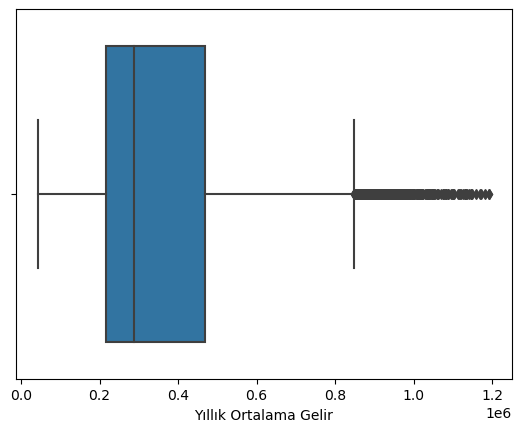

In [6]:
sns.boxplot(X["Yıllık Ortalama Gelir"]);

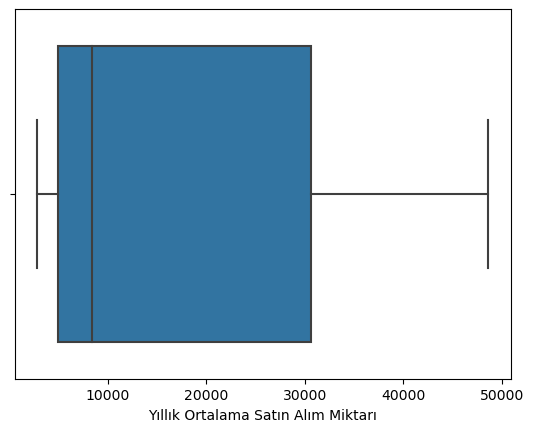

In [7]:
sns.boxplot(X["Yıllık Ortalama Satın Alım Miktarı"]);

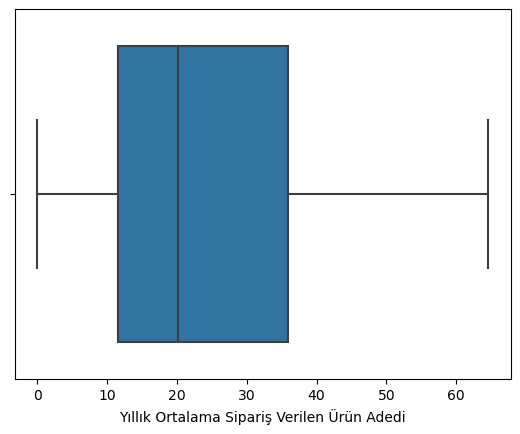

In [8]:
sns.boxplot(X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]);

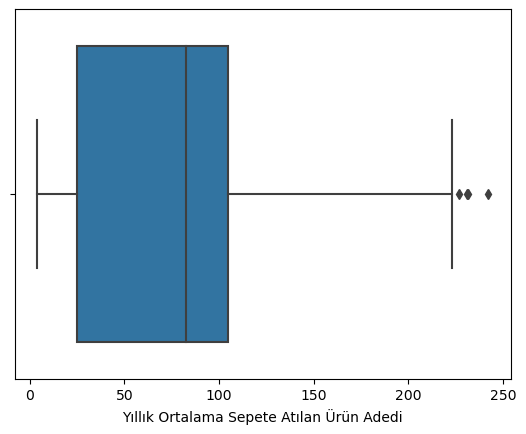

In [9]:
sns.boxplot(X["Yıllık Ortalama Sepete Atılan Ürün Adedi"]);

Evet boxplot grafiği ile daha iyi anladık ki sadece iki sütunda aykırı veri var:
- Yıllık Ortalama Gelir
- Yıllık Ortalama Sepete Atılan Ürün Adedi

Şimdi ise bu aykırı verilere nasıl ele alacağımızı tartışacağız ama ondan önce bir kod ile bu aykırı verilerin kaç tane olduğunu ve bu etiketlerin hedef yani bağımlı değişken ile ne kadar ilgili olduğunu araştıracağız sonra bir işlem yapacağız.

In [10]:
import seaborn as sns

def remove_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        
        outliers_index = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        
        print(" '{}' etiketi için aykırı veri sayısı : {}".format(column,len(list(outliers_index))))
        

remove_outliers(X[["Yıllık Ortalama Gelir","Yıllık Ortalama Sepete Atılan Ürün Adedi"]])


 'Yıllık Ortalama Gelir' etiketi için aykırı veri sayısı : 380
 'Yıllık Ortalama Sepete Atılan Ürün Adedi' etiketi için aykırı veri sayısı : 4


"Yıllık Ortalama Sepete Atılan Ürün Adedi" etiketinde çok fazla bir aykırı veri yok. Ama "Yıllık Ortalama Gelir" etiketi için aykırı veri sayısı gerçekten çok yüksek. Şimdi ise bir korealasyon testi yapacağız ve ona göre aykırı verilere ne yapacağımıza karar vereceğiz.

In [11]:
verilerimiz=X[["Yıllık Ortalama Gelir", "Yıllık Ortalama Sepete Atılan Ürün Adedi"]]

korelasyon_yapilacak_veri_seti=pd.concat([verilerimiz,pd.DataFrame(y,columns=["Öbek İsmi"])],axis=1)
korelasyon_yapilacak_veri_seti.corr()

,Yıllık Ortalama Gelir,Yıllık Ortalama Sepete Atılan Ürün Adedi,Öbek İsmi
Yıllık Ortalama Gelir,1.000000,0.145425,0.086821
Yıllık Ortalama Sepete Atılan Ürün Adedi,0.145425,1.000000,0.736725
Öbek İsmi,0.086821,0.736725,1.000000


Burada bakıldığı üzere yıllık ortalama sepete atılan ürün adedinde korealasyon katsayıyı yüksek hem zaten aykırı veri sayısıda azdı. Bu yüzden bu değişkene bir çözüm uygulamak yerine böyle bırakacağız. Yıllık Ortalama Gelir değişkeninde pek öbek ismi ile ilişkisi yok ama elimizde aykırı veri olduğu için biz bu aykırı değerler üzerinde baskılama tekniği kullanacağız.

In [12]:
# Burada boxplot grafiğinde görünen aykırı verileri alıyoruz. Daha sonra ise verideki dağılımın %25 ve %75 değerlerine baskılıyoruz.
Q1 = X['Yıllık Ortalama Gelir'].quantile(0.25)
Q3 = X['Yıllık Ortalama Gelir'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

X.loc[(X["Yıllık Ortalama Gelir"]<lower_bound),"Yıllık Ortalama Gelir"]=lower_bound
X.loc[(X["Yıllık Ortalama Gelir"]>upper_bound),"Yıllık Ortalama Gelir"]=upper_bound




# Baskılama tekniğini bize gelecek test veri setindeki değer içinde uyguluyoruz.
Q1 = test['Yıllık Ortalama Gelir'].quantile(0.25)
Q3 = test['Yıllık Ortalama Gelir'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

test.loc[(test["Yıllık Ortalama Gelir"]<lower_bound),"Yıllık Ortalama Gelir"]=lower_bound
test.loc[(test["Yıllık Ortalama Gelir"]>upper_bound),"Yıllık Ortalama Gelir"]=upper_bound


<a id="EDA"></a>
## Veri Görselleştirme

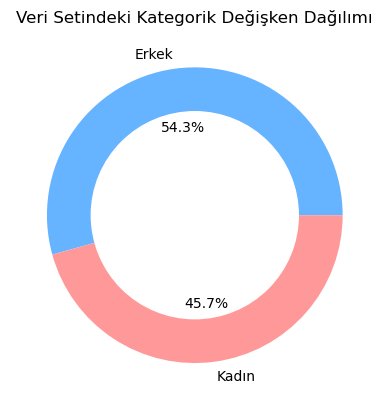

In [44]:
colors = ['#66b3ff','#ff9999']
ham_veriler_cinsiyet=dict(train["Cinsiyet"].value_counts())#Burada Erkekleri ve kadınların sayısının kaç tane olduğuna dair bir sözlük oluşturuyoruz.

frequency_cinsiyet=list(ham_veriler_cinsiyet.values())
kategoriler_cinsiyet=list(ham_veriler_cinsiyet.keys())

# Pie chart grafiğini oluşturun
plt.pie(frequency_cinsiyet,labels=kategoriler_cinsiyet ,colors=colors,
        autopct='%1.1f%%')

# Merkezdeki beyaz daireyi (donut şekli) eklemek için:
circle=plt.Circle((0,0),0.70,color='white')
fig=plt.gcf()
fig.gca().add_artist(circle)

# Grafik üzerine başlık ekleme
plt.title('Veri Setindeki Cinsiyet Değişkenin Dağılımı');

Göründüğü üzere erkekler bu veri setinde daha fazla sayıya sahip

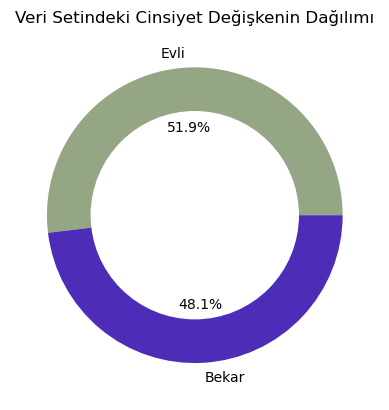

In [47]:
colors = ['#94A684','#4D2DB7']
ham_veriler_medeni_durum=dict(train["Medeni Durum"].value_counts())#Burada insanların medeni durumunu alıyorum sözlük tipinde

#Grafikte Kullanıalcak verileri hazırlıyoruz.
frequency_medeni_durum=list(ham_veriler_medeni_durum.values())
kategoriler_medeni_durum=list(ham_veriler_medeni_durum.keys())

# Pie chart grafiğini oluşturuyoruz
plt.pie(frequency_medeni_durum,labels=kategoriler_medeni_durum ,colors=colors,
        autopct='%1.1f%%')

# Donut Grafiğine dönüştürüyoruz. Yani merkeze beyazlık ekliyoruz:
circle=plt.Circle((0,0),0.70,color='white')
fig=plt.gcf()
fig.gca().add_artist(circle)

# Grafiğe başlık ekliyoruz.
plt.title('Veri Setindeki Cinsiyet Değişkenin Dağılımı');

Bu veri setinde evli sayısının daha fazla olduğunu anlamış olduk.

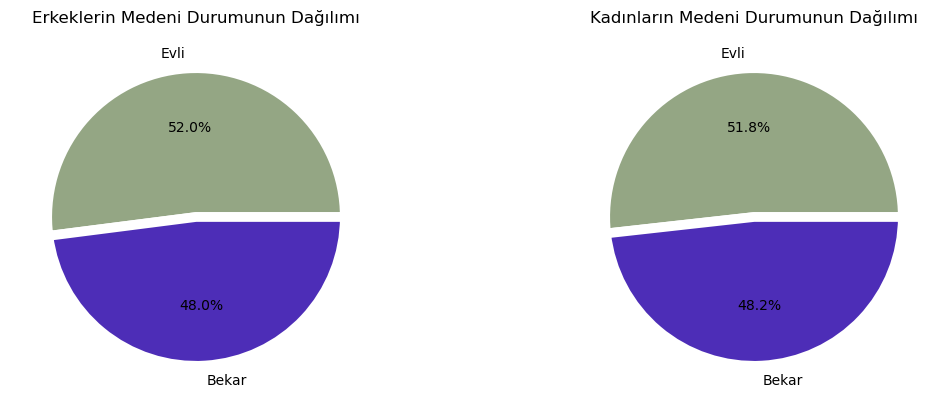

In [143]:
colors1 = ['#ff9999','#66b3ff','#99ff99']
colors2 = ['#ffb3e6','#c2c2f0','#ffb366']


ham_veriler_medeni_durum_sorgu1=train[train["Cinsiyet"]=="Erkek"]

frequency_medeni_durum_sorgu1=list(dict(ham_veriler_medeni_durum_sorgu1["Medeni Durum"].value_counts()).values())
kategoriler_medeni_durum_sorgu1=list(dict(ham_veriler_medeni_durum_sorgu1["Medeni Durum"].value_counts()).keys())


ham_veriler_medeni_durum_sorgu2=train[train["Cinsiyet"]=="Kadın"]

frequency_medeni_durum_sorgu2=list(dict(ham_veriler_medeni_durum_sorgu2["Medeni Durum"].value_counts()).values())
kategoriler_medeni_durum_sorgu2=list(dict(ham_veriler_medeni_durum_sorgu2["Medeni Durum"].value_counts()).keys())


fig, axs = plt.subplots(1, 2,figsize=(12,6))

# İlk pie chart'ı sol tarafa yerleştiriyoruz
axs[0].pie(frequency_medeni_durum_sorgu1,labels=kategoriler_medeni_durum_sorgu1 ,colors=colors,
        autopct='%1.1f%%',wedgeprops={'linewidth':7,'edgecolor':'white'})

axs[0].set_title('Erkeklerin Medeni Durumunun Dağılımı')



# İkinci pie chart'ı sağ tarafa yerleştiriyoruz
axs[1].pie(frequency_medeni_durum_sorgu2,labels=kategoriler_medeni_durum_sorgu2 ,colors=colors,
        autopct='%1.1f%%',wedgeprops={'linewidth':7,'edgecolor':'white'})

axs[1].set_title('Kadınların Medeni Durumunun Dağılımı')

plt.subplots_adjust(wspace=0.5)

Erkeklerin çoğunun evli olduğunu gördük bu grafikte

In [68]:
train.head()

,index,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


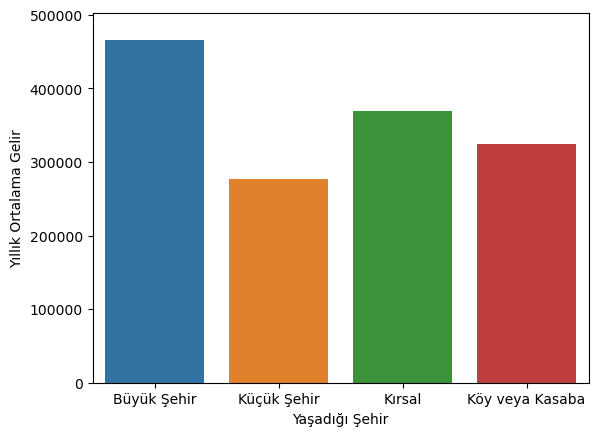

In [101]:
sns.barplot(data=train,x="Yaşadığı Şehir",y="Yıllık Ortalama Gelir",errwidth=0);

Buradaki sonuç beni biraz şaşırtıyor çünkü kırsal kesim daha fazla gelire sahip. Yani ben aslında kırsal kesimin yıllık ortalaam gelirinin bu kadar fazla oalcağını tahmin etmedi. Hadi şimdi bide ne kadar harcama yaptıklarına bakalım.

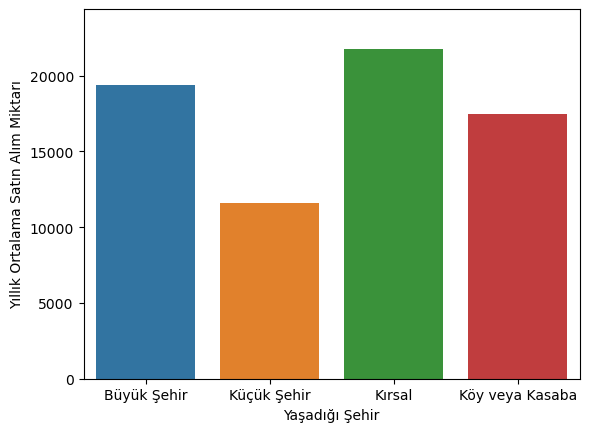

In [100]:
sns.barplot(data=train,x="Yaşadığı Şehir",y="Yıllık Ortalama Satın Alım Miktarı",errwidth=0);

Evet veri setindeki değerler bizi şaşırtmaya devame ediyor. Çünkü kırsal kesin aslında yıllık ortalama geliri en fazla olan ikinci grup iken en fazla harcama yapan grup oluyor.

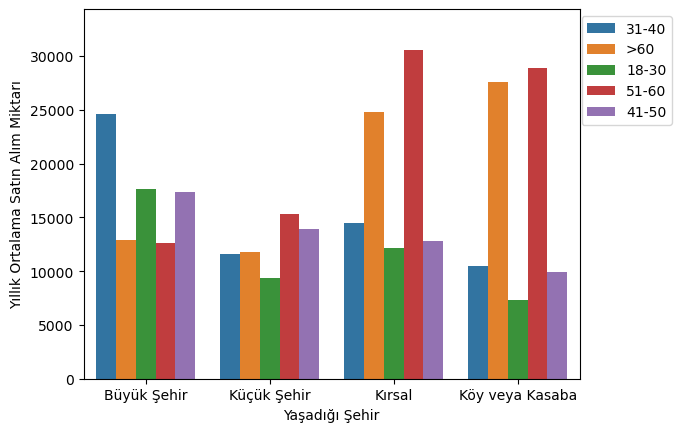

In [99]:
ax=sns.barplot(data=train,x="Yaşadığı Şehir",y="Yıllık Ortalama Satın Alım Miktarı",hue="Yaş Grubu",errwidth=0);
ax.legend(loc="upper right",bbox_to_anchor=(1.20, 1))

Kırsal kesimde satın alım miktarı 51-60 yaş arası çok fazla. Hatta kırsal kesimde bu kadar satın alım miktarı olmasının sebebi bu yaş grubudur. Tabi 60 yaş üstü de gerçekten satın alımı fazla. Bence bu yaş grubunun bu kadar satın alım miktarı yapmasının sebebi bir yaştan sonra kırsal kesime çekilip hayatını yaşamasıdır ya da torunlarına, sevdiklerine veya çocuklarına iyi bir hayat yaşamasını sağlamak için bu kadar harcama yapıyorlardır.

Tabi şimdi birde bölge bazında değilde sadece ortalama ve yaş grubu değerlerini kullanrak bir grafik oluşturalım ve hangi yaş grubun ortalama olarak en fazla harcama yaptığını öğrenelim

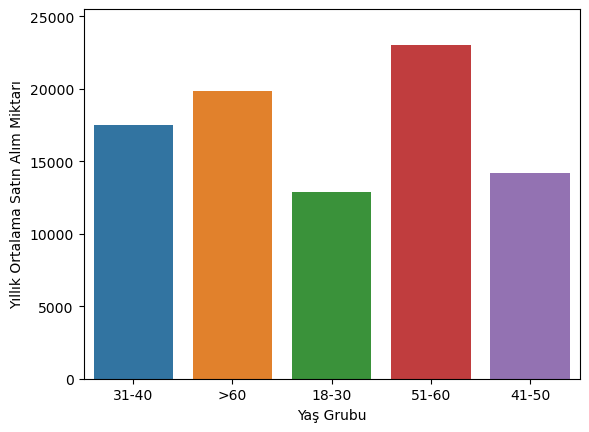

In [98]:
sns.barplot(data=train,x="Yaş Grubu",y="Yıllık Ortalama Satın Alım Miktarı",errwidth=0);

Evet sonuçlar bizi şaşırtmıyor 51-60 yaş ve 60 üstü gruplar gerçekten çok fazla satın alım miktarına sahip. Tabi burada böyle olmasının sebebi biraz daha araştırılması gerekir çünkü veri setinden bu bilgi alınamaz. Bunun için anket gibi bir şey düzenlenmesi gerekir. Tabi 51-60 ve >60 grup üstünü nasıl ankete alınır o biraz tartışılır. Ama biz burada biraz daha analiz yaparsak az çok fikir elde edebiliriz. Ya da hangi kategori ile ilgilendiğini öğrenirsek biraz daha elimize bilgi geçecektir. Hadi o zaman şimdi ise hangi yaş grubunun hangi kategori ile daha fazla ilgilendiğine bakalım.

In [78]:
train.head()

,index,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


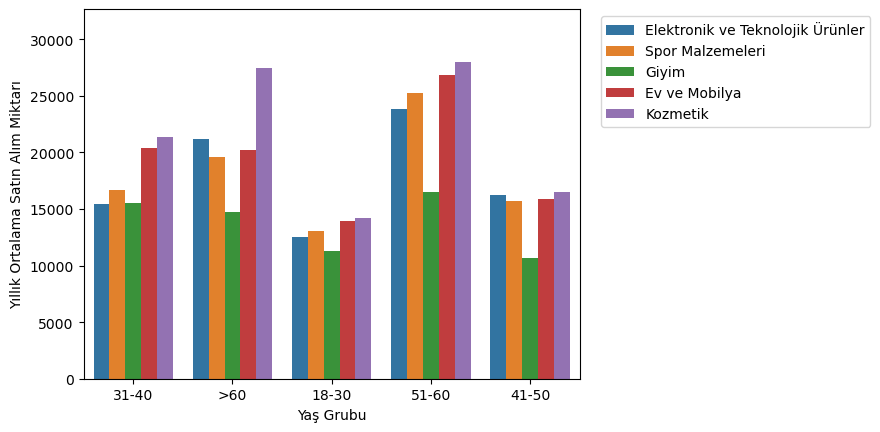

In [97]:
ax=sns.barplot(data=train,x="Yaş Grubu",y="Yıllık Ortalama Satın Alım Miktarı",hue="En Çok İlgilendiği Ürün Grubu",errwidth=0);
ax.legend(loc="upper right",bbox_to_anchor=(1.60, 1))

Şimdi bu görsel üzerinde biraz düşünmemiz gerekiyor. Çünkü bu görsel de 51-60 yaş arası grubunun kozmetik ile çok ilgilendiğini söylüyor. Yani bence bu biraz yanıltıcı sebebi ise bence o kozmetik ürünlerini kendileri için alıyor gibi gösterselerde başkası için alıyorlar. Yani bu başkasından kasıt, ticaret gibi değil. Sadece torunları ya da çocukları için alıyor olabilirler. Ayrıca giyim o yaş için düşük gibi gözüksede aslında her grupta düşük yani bu da demekki giyim kategorisi bu veri setinde pek satış yapan bir kategori değil. Ama buna rağmen yine en yüksek 51-60 yaş grup arasında olmayı başarıyor giyim kategorisi.

51-60 yaş grup arasınnda ev ve mobilya kategorisine de düşkünlük olduğunu görüyoruz. Spor kısmı biraz şaşıtrıcı gibi görüksede aslında 51-60 yaş için biraz normal bir değer çünkü onlarında daha iyi bir yaşam için spor yapmaları gerekiyor. Tabi elekrik ve teknolojik ürünler kısmı biraz şaşırtıcı bence bu konuda çocukların biraz payı var gibi.

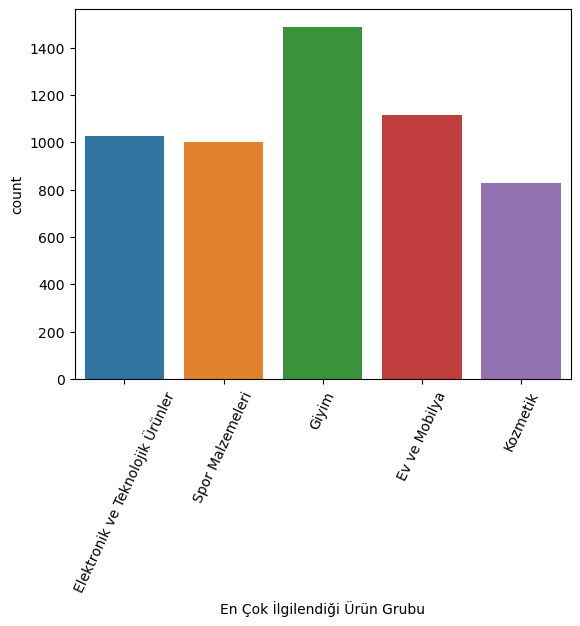

In [230]:
sns.countplot(data=train,x="En Çok İlgilendiği Ürün Grubu")
plt.xticks(rotation=65)
plt.show();

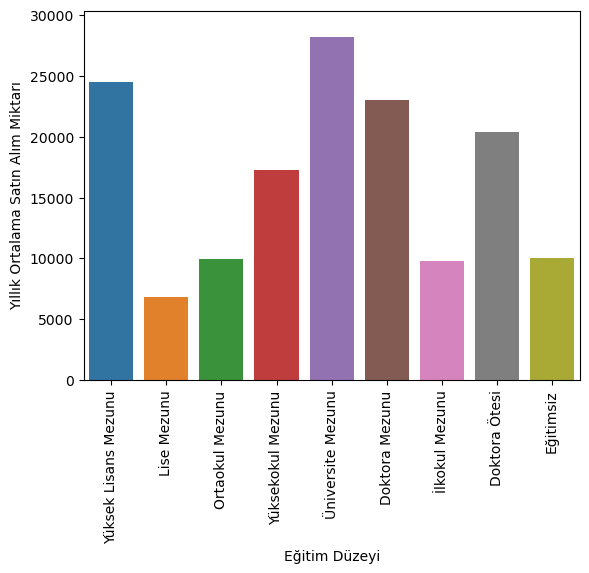

In [109]:
ax=sns.barplot(data=train,x="Eğitim Düzeyi",y="Yıllık Ortalama Satın Alım Miktarı",errwidth=0);
plt.xticks(rotation=90)
plt.show();

Evet göründüğü üzere Üniversite Mezunları daha fazla harcıyorlar ve onları sonra Yüksek Okul Mezunları takip ediyor. En az harcayan kısım ise Lise Mezunları oluyor. Yani çok kaba bir tabirle söylemek gerekirse insanların eğitimleri artınca harcamalarıda artıyor. Tabi burada bence kilit nokta kazanılan paradır. Yani eğitim artınca yıllık ortalama gelirde artar, yıllık ortalama gelirde arttınca satın alım miktarıda az çok artar. Hadi birdaki grafikte bakalım bu durum gerçekten böyle mi?

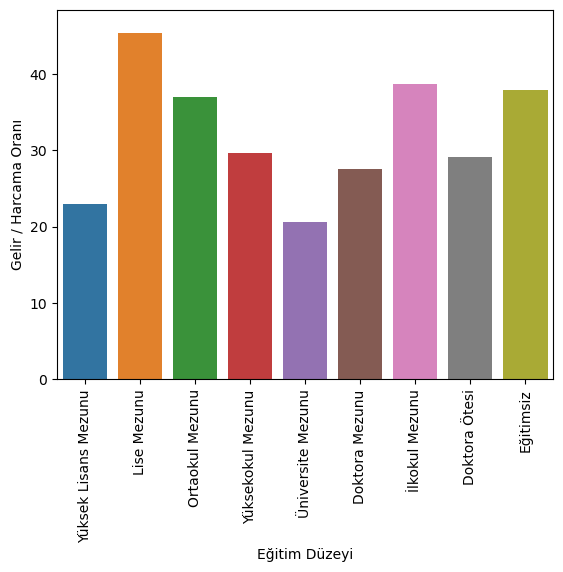

In [114]:
# Yıllık ortalama geliri yıllık ortalama satın alım miktarına bölüyoruz bu sayede elimizde eğitim düzeyi belirli olan insanların
#ortalama olarak yaptığı harcamalar çıkıyor. Yani gelirine oranla ne kadarını harcadığı ortaya çıkıyor
train["Gelir / Harcama Oranı"]=train["Yıllık Ortalama Gelir"]/train["Yıllık Ortalama Satın Alım Miktarı"]

ax=sns.barplot(data=train,x="Eğitim Düzeyi",y="Gelir / Harcama Oranı",errwidth=0)
plt.xticks(rotation=90)
plt.show();

Burada göründüğü üzere en fazla harcayan Lise Mezunu insanlar. Hatta nereden bakacak olursa gelirinin %45'ini harcıyorlar. En az ise Üniversite Mezunu insanlar'dır. Hatırlıyormusunuz bir az önce eğitim artınca insanlar daha fazla harcıyor demiştim. Şimdi göründüğü üzere bu değişti. ve artık diyoruz ki insanların eğitimleri artınca biraz daha az harcıyorlar paralarını. Tabi geriye kalan paraları ile yatırım mı yapıyorlar yoksa biriktiriyorlar mı orası bilinmez. Ama şu biliniyor ki bizim asıl müşterimizi daha az eğitime sahip insanlardır.

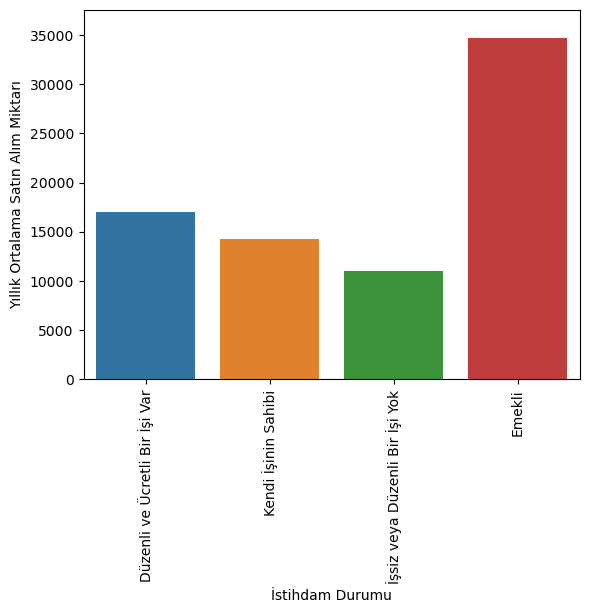

In [232]:
ax=sns.barplot(data=train,x="İstihdam Durumu",y="Yıllık Ortalama Satın Alım Miktarı",errwidth=0);
plt.xticks(rotation=90)
plt.show()

Evet göründüğü üzere emeklilerin yıllık ortalama satın alımı çok daha fazla. Beklenilen gibi işsiz veya düzenli bir işi yok diyen kişiler ise alımı gerçekten çok az. Peki acaba yaş ortalamasının işe göre dağılımı kaç bide ona bakalım.

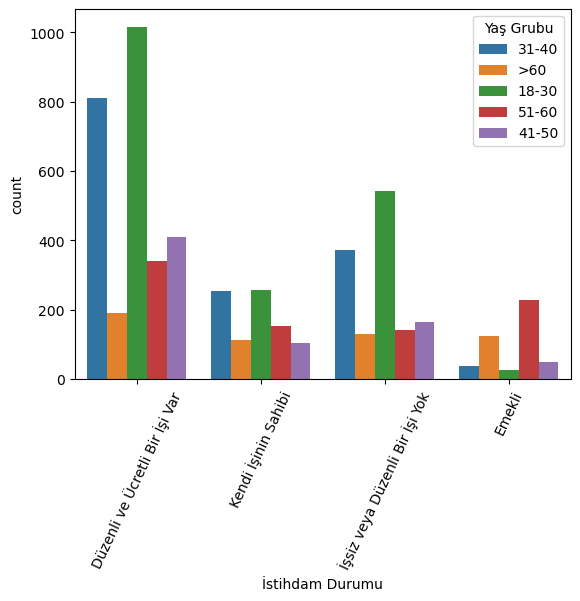

In [126]:
ax=sns.countplot(data=train,x="İstihdam Durumu",hue="Yaş Grubu")
plt.xticks(rotation=65)
plt.show()

Burada aslında farkettiğimiz üzere emeklilerin genel anlamda veri setinde sayısı düşük ama en fazla harcamayı da emekliler yapıyor. Bu da demektir ki emeklilerin yıllık ortalama geliri diğerlerine göre yakın ya da fazla. Tabi emekli tarafında 31-40 yaş arası emekli var bunlar aykırı veride olabilir diye düşünüyorum. Ama veri seti yapılırken herhangi bir bilgim olmadığı için bu verileri engelleyemem. Hatta 18-30 yaş arasında bile emekli sayılan var. Bence bu bir aykırı veri. Ama veri setinden bilgi az olduğu için bu aykırı verileri kabulleneceğiz ve yolumuza devam edeceğiz. Ama dediğim gibi bu verilerin tekrardan gözden geçirilmesi hatta bence düzenlenmesi gereklidir.

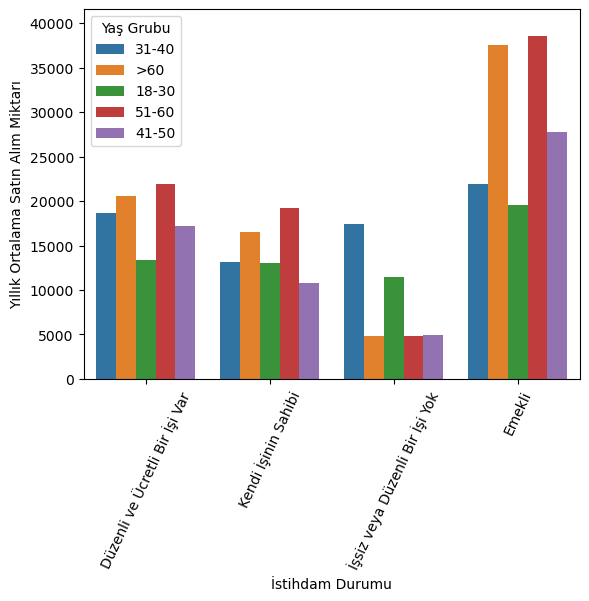

In [129]:
ax=sns.barplot(data=train,x="İstihdam Durumu",y="Yıllık Ortalama Satın Alım Miktarı",hue="Yaş Grubu",errwidth=0);

plt.xticks(rotation=65)


plt.show()

Bu grafikten çıkaracağımız sonuç ise aslında genel anlamda 51-60 yaş arası satın alım gerçekten çok fazla. Yani işsiz veya düzenli bir işi olmadığı sürece yıllık ortalama geliri çok da olsa az da olsa genellikle çok harcıyorlar.

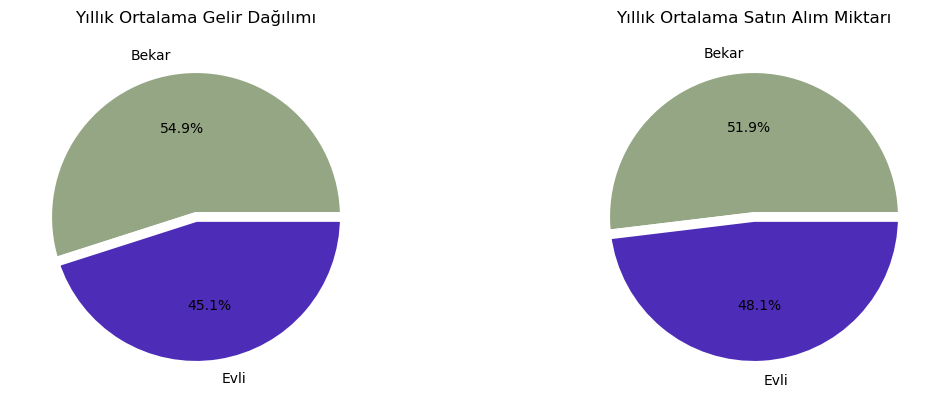

In [142]:
#Bekarların ve Evlilerin Yıllık ortalama gelirlerini alıyoruz
bekarlarin_yilik_ortalama_geliri=train[train["Medeni Durum"]=="Bekar"]["Yıllık Ortalama Gelir"].mean()
evlilerin_yillik_ortalama_geliri=train[train["Medeni Durum"]=="Evli"]["Yıllık Ortalama Gelir"].mean()

# Verileri Pie charts grafiğinin anlayabileceği bir kıvama getiriyoruz.
medeni_durum_yillik_ortalama_gelir=[bekarlarin_yilik_ortalama_geliri,evlilerin_yillik_ortalama_geliri]
medeni_durumlar=["Bekar","Evli"]


#Bekarların ve Evlilerin Yıllık ortalama gelirlerini alıyoruz
bekarlarin_yilik_ortalama_satin_alim=train[train["Medeni Durum"]=="Bekar"]["Yıllık Ortalama Satın Alım Miktarı"].mean()
evlilerin_yillik_ortalama_satin_alim=train[train["Medeni Durum"]=="Evli"]["Yıllık Ortalama Satın Alım Miktarı"].mean()

# Verileri Pie charts grafiğinin anlayabileceği bir kıvama getiriyoruz.
medeni_durum_yillik_ortalama_satin_alim=[bekarlarin_yilik_ortalama_satin_alim,evlilerin_yillik_ortalama_satin_alim]
medeni_durumlar=["Bekar","Evli"]

# Pie chart grafiğini oluşturuyoruz
fig, axs = plt.subplots(1, 2,figsize=(12,6))


# İlk pie chart'ı sol tarafa yerleştiriyoruz
axs[0].pie(medeni_durum_yillik_ortalama_gelir,labels=medeni_durumlar ,colors=colors,
        autopct='%1.1f%%',wedgeprops={'linewidth':7,'edgecolor':'white'})

axs[0].set_title('Yıllık Ortalama Gelir Dağılımı')



# İkinci pie chart'ı sağ tarafa yerleştiriyoruz
axs[1].pie(medeni_durum_yillik_ortalama_satin_alim,labels=medeni_durumlar ,colors=colors,
        autopct='%1.1f%%',wedgeprops={'linewidth':7,'edgecolor':'white'})

axs[1].set_title('Yıllık Ortalama Satın Alım Miktarı')




 # Grafiklerin daire şeklinde görünmesi için

 # Grafikler arasındaki boşluğu düzenlemek için

plt.subplots_adjust(wspace=0.5)

Burada da göründüğü üzere bekarların yıllık ortalama geliri daha fazla iken daha fazla harcıyorlar. Tabi bunun sebebi yaş da olabilir. Çünkü deminki notlarda dediğimiz gibi en fazla harcama yapanlar yüksek yaşlardakilerdir ve bu yüksek yaşlardakilerin bekar olma olasışığı biraz var gibi. Tabi bunu incelemek gerekir hadi inceleyelim!

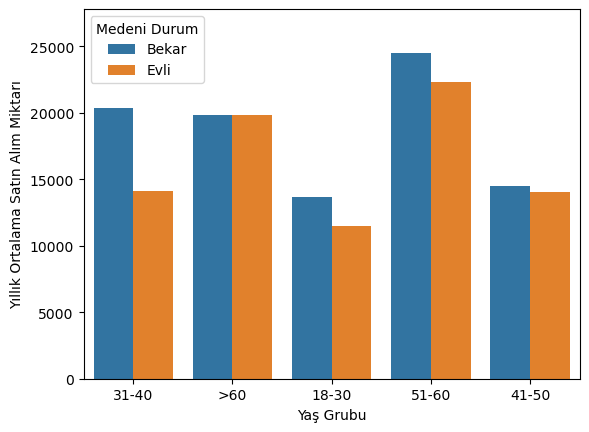

In [233]:
sns.barplot(data=train,x="Yaş Grubu",y="Yıllık Ortalama Satın Alım Miktarı",hue="Medeni Durum",errwidth=0);

Aslında haksız çıktım. Çünkü 60 yaş üstünde evliler daha fazla harcarken 51-60 arasında ise bekarlar daha fazla harcıyor. Yani yüksek yaşlardakiler birbirini denegeliyor. Burada bekarların daha fazla harcamasının sebebi ise 31-40 yaş arasındakilerdir. Tabi bu yaşda evli olmadığı için muhtemelen canı ne isterse onu alıyor. Orası tartışılır tabi ki. Hadi şimdi ise hangi cinsiyetin hangi kategori ile daha çok ilgilendiğini keşfedelim.

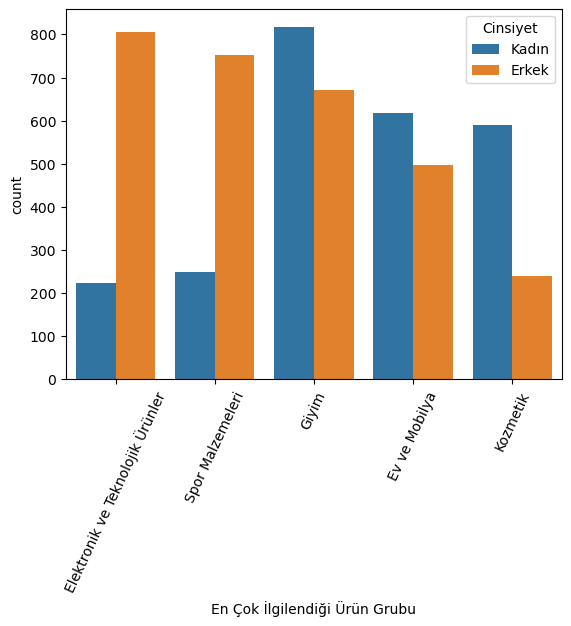

In [164]:
ax=sns.countplot(data=train,x="En Çok İlgilendiği Ürün Grubu",hue="Cinsiyet")
plt.xticks(rotation=65);

Kadınlar en fazla giyim ile ilgileniyorlar bence bu gayet normal. Daha sonra ise ev ve mobilya ile çok ilgileniyorlar spor ve teknolojik ürünler ile de pek fazla ilgilenmiyorlar. Erkekler ise en fazla Elektronik ve Teknolojik Ürünler kategorisi ile ilgileniyor. Daha sonra ise bunları spor, giyim, ev ve mobilya kategorileri takip ediyor. Erkekler ise kozmetik kategorisi ile çok az ilgileniyor.

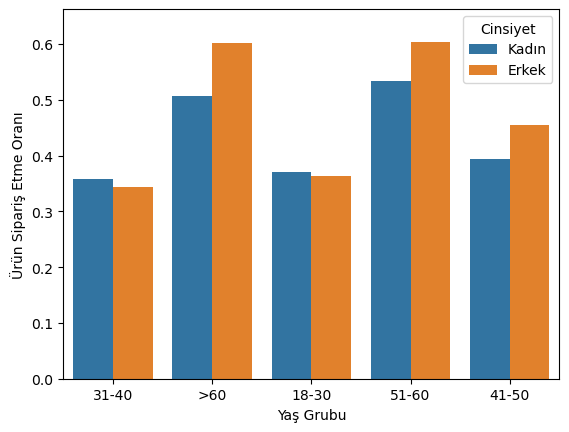

In [174]:
# Yıllık Ortalama sipariş verilen ürün adedini yıllık ortalama sepete atılan ürün sayısına bölüyoruz bu sayede sepete atılan
#ürünlerin yüzde kaçının sipariş edildiğini buluyoruz.
train["Ürün Sipariş Etme Oranı"]=train["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]/train["Yıllık Ortalama Sepete Atılan Ürün Adedi"]


sns.barplot(data=train,x="Yaş Grubu",y="Ürün Sipariş Etme Oranı",hue="Cinsiyet",errwidth=0);


Burada göründüğü üzere 60 yaş üstü kişiler sepete attığını alma oranı daha fazla. Bu nedendir ki bu veri setindeki internet mağazası için bir reklam çıktıımızda 60 yaş üstü insanlar için pek elverişli olmaz. Diğer gruplara baktığımızda ise 31-40 ve 18-30 yaş grupları sepete bir şeyler ekliyor ve sonra onu almıyor. Buda bizim için bence fırsatdır. Bu kişilerin internet mağazamızı tekrar ziyaret etmesini sağlayacak reklamlar gösterek almasını sağlayabiliriz.

Burada diğer ibr husu ise 41 yaştan sonra kadınlar sepete attığını daha az alma oranına sahip iken erkekler daha fazla bir orana sahip. 40 ve daha düşük yaşalarda ise erkekler sepete ekliyor ve sonra heralde unutuyorr ve gidiyorr.

Şimdi artık hedef değişkenimiz için bir kaç analiz yapacağız.

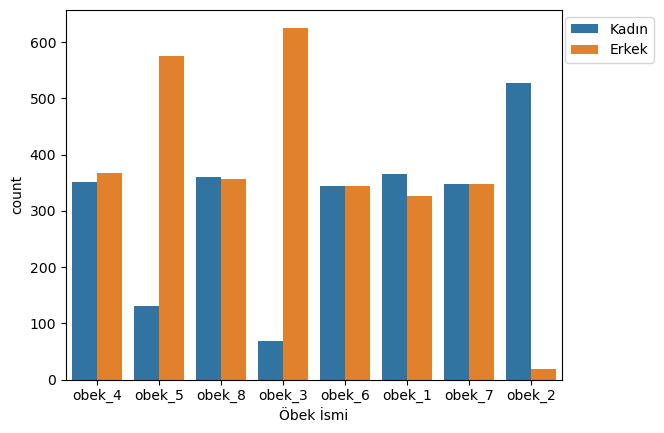

In [200]:
ax=sns.countplot(data=train,x="Öbek İsmi",hue="Cinsiyet");
ax.legend(loc="upper right",bbox_to_anchor=(1.20, 1));

Burada ilgimi çeken 2 değer var obek_4 değerinde nerdeyse hiç kadın yok gibi yani gerçekten aşırı az. Aynı durum obek_8 değerinde de var bu değerde ise gerçekten erkek sayısı yok denecek kadar az. Hadi birazda yaş dağılımına bakalım.

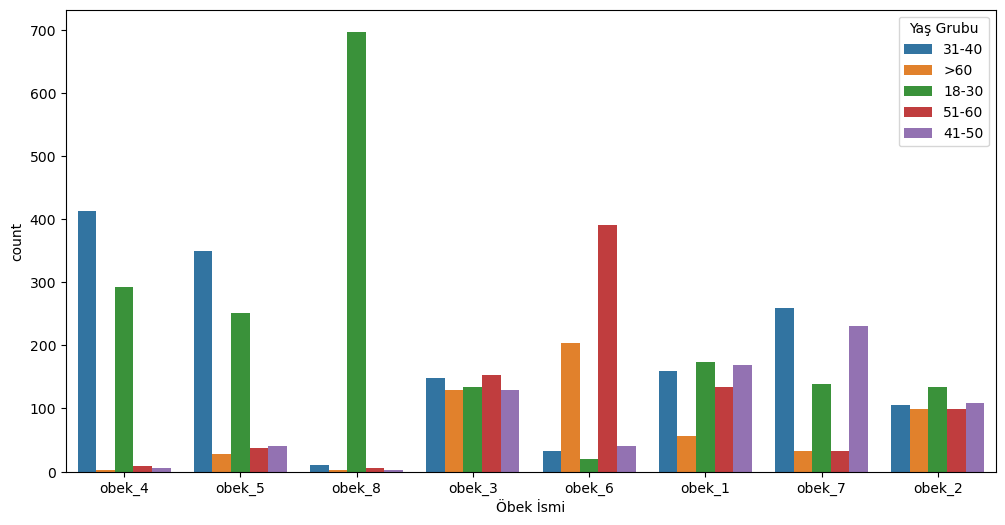

In [201]:
fig=plt.figure(figsize=(12,6))
ax=sns.countplot(data=train,x="Öbek İsmi",hue="Yaş Grubu");


Burada en çok dikkatimi çeken veri obek_8. Çünkü resmen 18-30 yaş arası gençler buraya toplanmış. Aslında aynı değerler obek_4 ve obek_5 içinde geçerli buralarda da genç sayısı oldukça fazla. obek_6 değerinde ise daha çok yaşlılar toplanmış. Bu da demekki burası yaşlıları barındıran bir öbek değeri. obek_3 ise toplanma alanı gibi herkese açık. obek_7 değeri ise biraz daha gençleri ağırlıyor ve yine aynı şekilde obek_1 değeride gençleri barındırır iken obek_8 değerinin de toplanma kampı gibi olduğunu görüyoruz. Hadi birde medeni durum bazında bakalım.

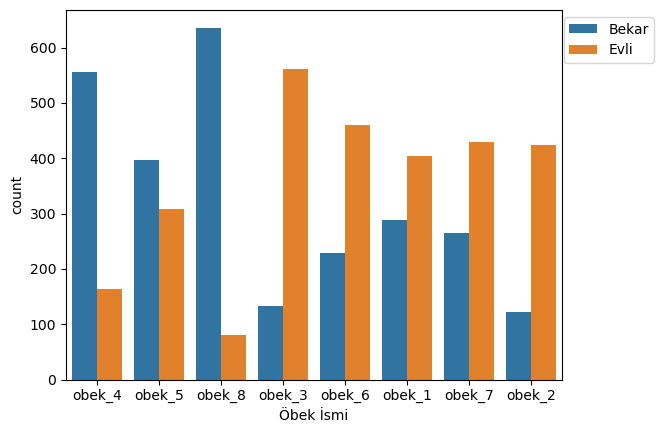

In [202]:
ax=sns.countplot(data=train,x="Öbek İsmi",hue="Medeni Durum")
ax.legend(loc="upper right",bbox_to_anchor=(1.20, 1));

Buradan çıkaracağımız bilgiye göre obek_4,obek_5 ve obek_8 daha fazla bekar barındırır iken obek_3, obek_6, obek_1, obek_7 ve obek_2 değerleri ise daha çok evlileri içlerinden barındırıyor.

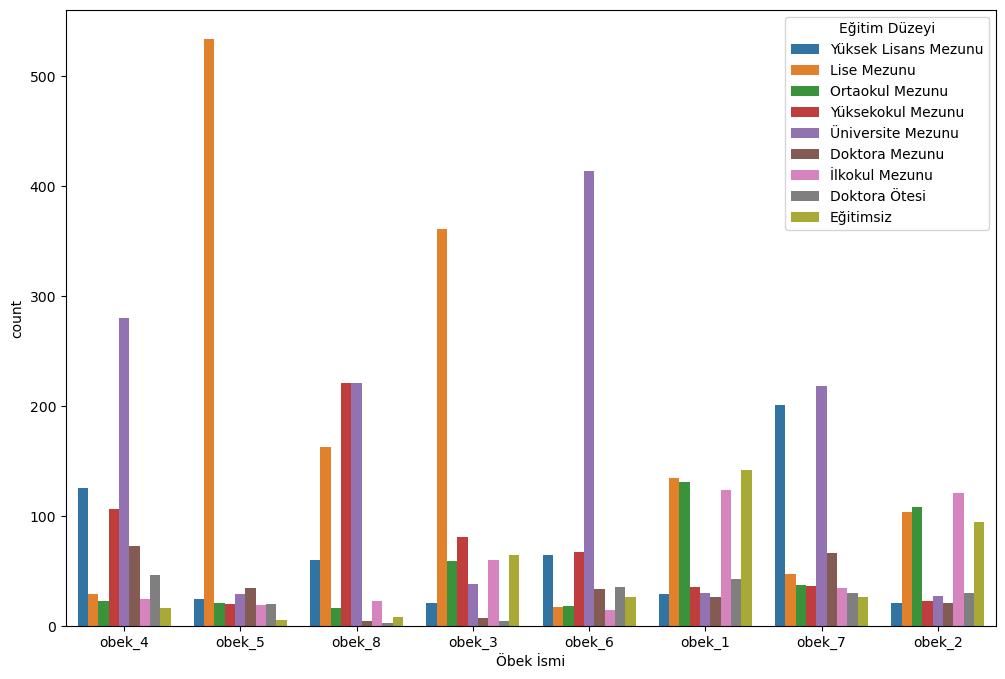

In [210]:
fig=plt.figure(figsize=(12,8))
ax=sns.countplot(data=train,x="Öbek İsmi",hue="Eğitim Düzeyi")

Buradan elde ettiğimiz bilgilere göre obek_5 değeri lise mazunları için inşa edilmiş bir öbek değeridir. oebk_4 ise içinde üniversite mezunlarını daha çok barındıyor ve ayrıca diğer eğitimi ve bence birazda harcaması yüksek bir ekibi barındırıyor. obek_8 değerinde ise yine iyi eğitim almış insanlar var ama bu sırayı tabiki lise mezunu birazcık bozuyor. obek_6 değeride bence harcaması yüksek bir gruba örnek olabilir. obek_1 ise daha az eğitim almış insnaları içinde barındırıyor. Aynı şekilde obek_2 değeride içinde daha az eğitim almış kişileri barındırıyorlar.

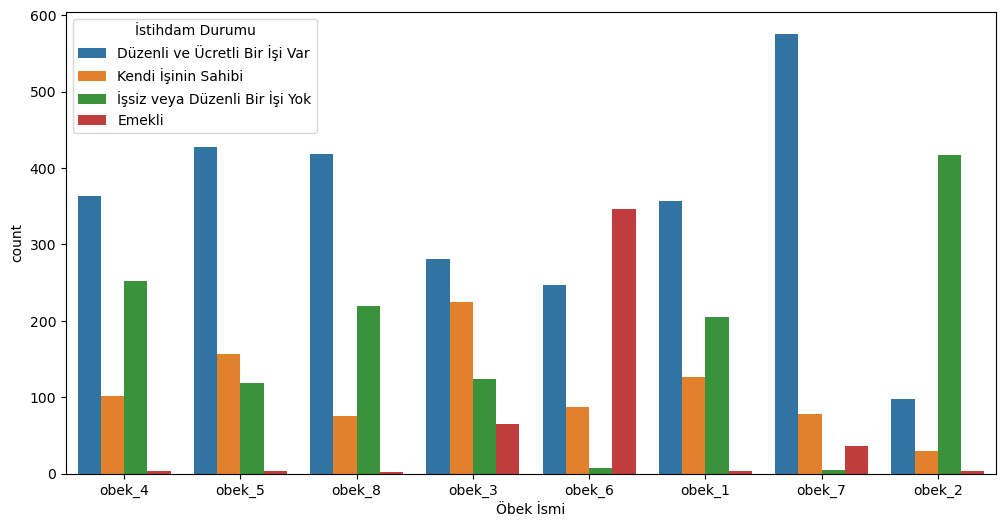

In [217]:
fig=plt.figure(figsize=(12,6))
sns.countplot(data=train,x="Öbek İsmi",hue="İstihdam Durumu");

Burada elde ettiğimiz bilgilere göre obek_7  düzenli ve ücretli ibr işi olanların tam seçeneği gibi gözüküyor. obek_2 ise işsiz veya düzenli bir işi olmayanların en uğrak yeri. Tabi obek_2'nin yıllık satın alım miktarının da yine düşük olduğunu tahmin ediyorum. obek_6 dağeri ise emekliler için resmen bir cennet olmuş. Çünkü o grupta gerçekten sayısı çok fazla ayrıca bu grubun yıllık ortalama satın alım miktarının da yine çok fazla olduğunu düşünüyorum.

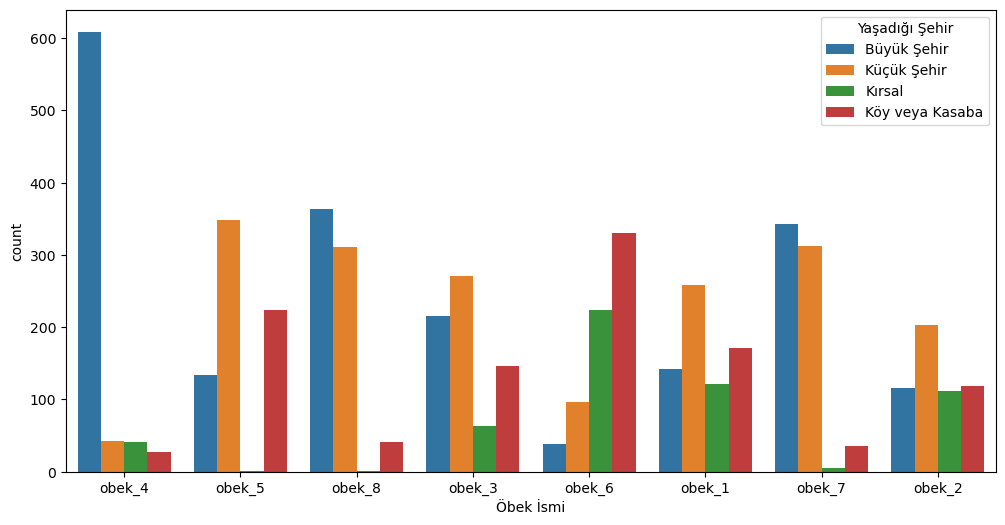

In [220]:
fig=plt.figure(figsize=(12,6))
sns.countplot(data=train,x="Öbek İsmi", hue="Yaşadığı Şehir");

Burada göründüğü üzere obek_4 degeri büyük şehir için çok fazla bir alıma sahip. obek_5 değerinde ise kırsal kesim gerçekten aşırı az hatta bence yok demek daha doğru olur. Aynı durumu obek_8 için de söylemek doğru olur. obek_3 değeri ise küçük şehirin en fazla toplandığı yerlerden biridir. obek_6 ise köy ve kasabada yaşayanların uğrak noktasıdır. Hatta önceki grafikten elde ettiğimiz verilere göre obek_6 en fazla yaşlı barındıran gruptur. obek_7 değeride yine kırsal kesimi arasına almak istemeyen bir grup.

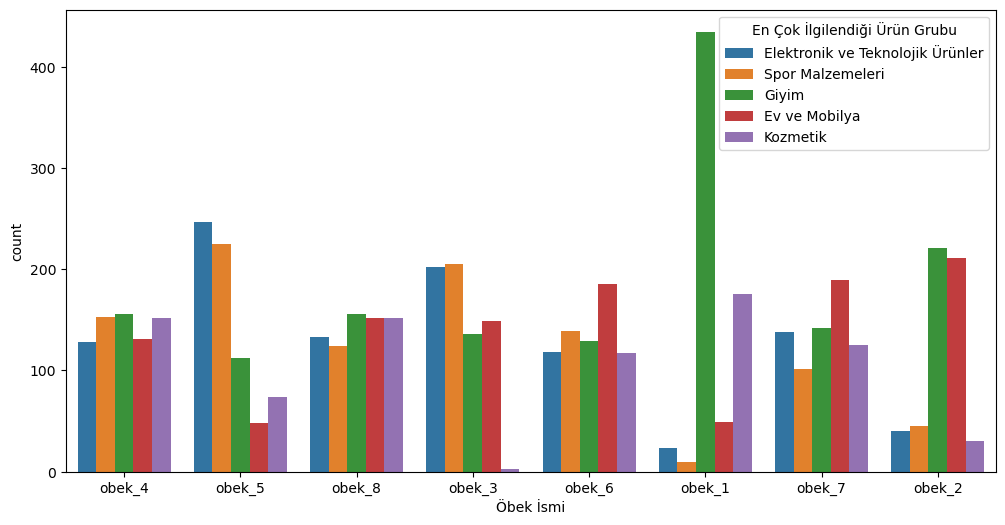

In [222]:
fig=plt.figure(figsize=(12,6))
sns.countplot(data=train,x="Öbek İsmi",hue="En Çok İlgilendiği Ürün Grubu");

obek_4 değeri her kategoriyi seven bir grup. obek_5 ise elektronik ve teknolojik ürünler ve spor malzemleri kategorilerini seviyorlar bunun en büyük sebebi ise obek_5 değerinin çoğu erkeklerden oluşuyor. obek_3 değerinde ise kozmetik gerçekten hiç yok gibi bunun yine en büyük sebebi erkeklerdir. obek_1 değerinde ise giyim kategorisinin fırladığını görüyoruz bunun sebebi ise kadınların çoğunlukla olmasıdır burada. obek_2 değerinde ise giyim, ev ve mobilya kategorilerinin bu kadar artmasının sebebi ise kadınalrın fazla olmasıdır. Diğer bir şeyi ise burada yaşlı insan sayısı yine fazla.

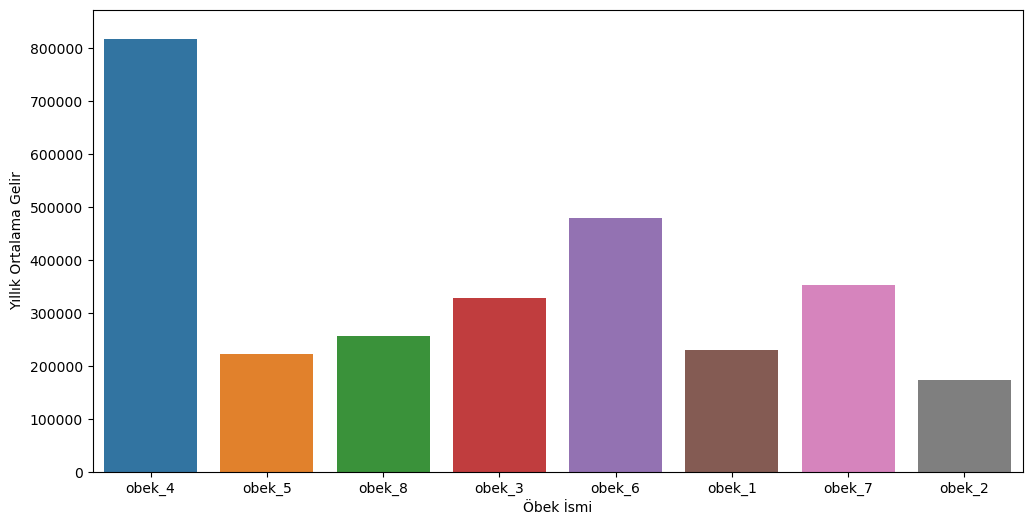

In [223]:
fig=plt.figure(figsize=(12,6))
sns.barplot(data=train,x="Öbek İsmi",y="Yıllık Ortalama Gelir",errwidth=0);

obek_4 değeri gerçekten yıllık ortalama geliri çok fazla. Yani bütün durumu iyi olan insanlar sanırım buraya toplanmış. Ondan sonra ise obek_6 geliyor ve onuda obek_7 takip ediyor. En düşük yıllık ortalama gelire sahip grup ise obek_2 grubudur. Bunun sebebi ise buranın çoğunlukla işsiz grup olmasıdır.

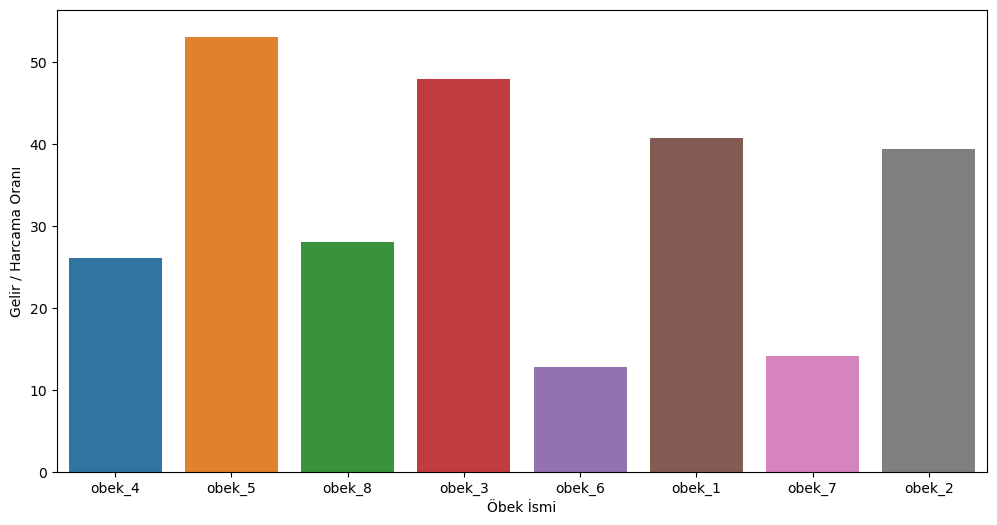

In [225]:
fig=plt.figure(figsize=(12,6))
sns.barplot(data=train,x="Öbek İsmi",y="Gelir / Harcama Oranı",errwidth=0);

obek_4 normalde en fazla gelire sahip değer ama yinede resmen en az harcayan gruplar arasındadır. En fazla ise obek_5 grubu harcıyormuş. Hatta obek_2 den sonra en az yıllık ortalama gelire sahip olan kısım obek_5. Yani zaten eğitimleri de genel olarak obek_5'in az belkide bu yüzden fazlaa harcıyorlar biriktirmek yerine. Daha sonra ise obek_3 geliyor. 

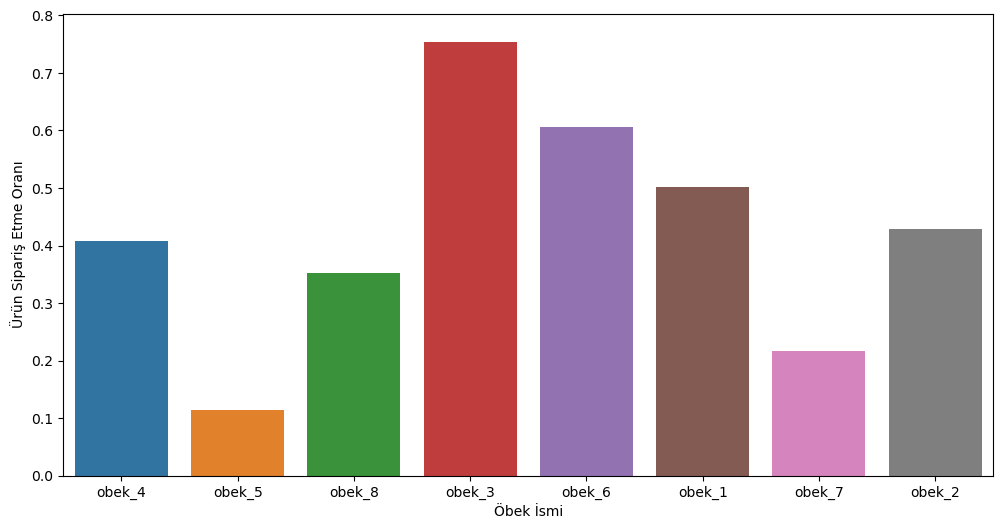

In [228]:
fig=plt.figure(figsize=(12,6))
sns.barplot(data=train,x="Öbek İsmi",y="Ürün Sipariş Etme Oranı",errwidth=0);

Burada ürün sipariş ettikten sonra alma oranı en fazla obek_3 değerindedir. Bunun sebebi yaş grubudur yani obek_3 ve obek_6 sepete koyduktan sonra direkt alıyor resmen. Bunun sebebi ise yaşlılardır yaşlılar da ise genel olarak ürün sipariş etme oranı yüksketir. obek_5 değeri ise yıllık ortalama geliri az olmasına rağmen en fazla sipariş eden grup evet ama aynı zamanda en fazla da sepete atıp istifleyen gruptur.

<a id="Ozet"></a>
## Veri Ön İşleme Özet

Burada veri ön işleme konusunda biraz ayrıntıya girdik. Tabi bazı kişiler bu kadar bilgi okumak ve bu kadar grafik görmek yerine kısa kısa hap bilgiler isteyecektik. Bu aşamada ise bu yapılması gereklidir.

1. Veri Setinde erkekleden kadınlardan daha fazladır aynı zamanda evliler bekarlardan daha fazladır.<br><br>
2. Erkekler ve kadınlar eşit ölçüde evlilik ve bekarlık oranlarına sahiplerdir.<br><br>
3. Bekarlar evlilerden daha fazla yıllık gelire ve daha fazla harcamaya sahiplerdir.<br><br>
4. Bu veri setinde yıllık ortalama gelir sıralaması şudur: Büyük Şehir > Kırsal > Köy Ve Kasaba > Küçük Şehir<br><br>
5. Bölgelere göre satın alım miktarı şöyledir : Kırsal > Büyük Şehir > Köy ve Kasaba > Küçük Şehir<br><br>
6. 51-60 ve >60 yaş grubu en fazla satın alıma sahiplerdir.<br><br>
7. Giyim kategorisi en fazla ilgi çeken kategoridir. Ama en az para ödenen kategoridir.<br><br>
8. Eğitim seviyesi arttıkça harcama oranı azalıyor. Yani eğitimsiz birisi parasının %60'ını vs. harcar iken yüksekokul mezunu birisi %20 sini harcıyor.<br><br>
9. Emekliler yıllık en fazla satın alımı yapan gruptur.<br><br>
10. Erkekler daha çok elektronik ve teknolojik ürünler kategorisi, spor malzemeleri katgorilerine çok ilgili, giyim ,ev ve moibya kaegorilerine daha az ilgili iken. Kadınlar ise giyim, ev ve mobilya ve son olarak kozmetik kategorilerine çok ilgililer.<br><br>
11. Genel olarak yaş arttıkça insanlar sepete koyduğu ürünü almaya daha meyili oluyor. Aksi takdirde genç yaşlarda ise sepete atıyor ve nadiren satın alıyor.<br><br>

**Şimdi ise Öbek isimlerini anlamlandırmaya çalışacağız**

- Öbek 1 : Kadın sayısı erkek sayısından biraz daha fazla. >60 biraz düşü gibi diğer yaş grupları hemen hemen aynı seviyed yani belirleyici etken yaş grubu değil. Evliler nerdeyse bekarlardan 100 kişi daha fazla. Buda daha az harcama yapılması demektir. Eğitimsiz ve Lise Mezunu sayısı baya var iken Üniversite Mezunu ve sonrası için sayı düşük. Bu da demekki bu kategoride biraz fazla harcama yapılma potansiyeli var. Emekli sayısı gerçekten hiç yok gibi en fazla ise düzenli bir iyi var değeridir. En fazla içinde küçük şehiri barındırıyor sonrasında ise köy ve kasaba, büyükşehir ve kırsal devam ediyor. Giyim ve kozmetik ürünlerine aşırı düşkünler bu da bence bu kategoriyi tanımlamak için mükemmel bir değer. Yıllık Ortalama geliri 5. grup. Gelir ve harcama oranına göre ücüncü grup yani bu da demektir ki bu kişiler gerçekten harcıyorlar. Ürün Sipariş etme oranına göre de üçüncüler yani gerçekten istediklerini sepete atıyorlar ve alıyorlar.


- Öbek 2 : Kadın sayısı gerçekten aşırı fazla. Yaş grubu dağılımı hemen hemen aynı. Bu kişierln çoğu evli. Öbek 1 gibi daha az eğitime sahip kişileri kapsıyorlar. Çok fazla işşiz veya düzensiz bir işi var etiketinden çok fazla var. Küçük şehirde daha fazla kalıyor bu grup diğer değerler ise hemen hemen eşit. Ev ve mobilya ve giyim kategorilerine gerçekten aşırı düşkün bir grup. Yıllık Ortalama geliri en az öbektir. Gelir/Harcama Oranı en fazla 4. kategoridir. Yani kazandığının çoğunu bu internet mağazasında harcıyorlar. Ürün Sipraiş etme oranında da yine 4. en sipariş eden kategoridir.


- Öbek 3 : Erkek Sayısı aşırı fazla. Yaş grubu hemen hemen aynı. Bir çoğu evli. Lise mezunu burada gerçekten tavan yapmış diğer değerler ise hemen hemen aynı. İstihdam durumu ise mediven gibi düzenli ve ücretli bir işi var> kendi işinin sahibi > işsiz veya düzenli bir işi yok > emekli. Büyük Şehir ve küçük şehirde çok kalıyorlar. Sonra bunu köy ve kasaba sonrada kırsal alan takip eder. Kozmetik haric diğer kategorilern hepsi hemen hemen aynı. Yıllık ortalam gelirde 4.sıraya sahipler. Gelir/Harcama oranında 2. sıraya sahipler. Ürün sipariş etme oranında ise birinciler yani tuttuğunu koparıyorlar ve sepete ekleyince alma oranı yüksek.


- Öbek 4 : Erkek ve kadın sayısı eşit gibi.  18-30 ve 31-40 yaş grubu arasın resmen buraya toplanmış ve bunların çoğu bekar. Buranın çoğu eğitime yatkın ve resmen bütün iyi eğitim almışlar buraya toplanmış. Düzenli veya ücretli bir işi var> işsiz> kendi işi var diye sıralanıyor ama emekli sayısı gerçekten yok gibi. Bu kişilerin çoğu hemde resmen tamamı büyük şehirde kalıyor. En çok ilgilendiği ürün grubu yok hepsine eşit şekilde ilgi gösteriyor.Yıllık Ortalama geliri en fazla iken harcama oraı için 4.sıradalar. Hatta yine gerçekten az bir değer bu çünkü %26 ya falan tekabul ediyor. Ürün sipariş etme kısmında ise beşinciyiz. ve %40 gibi bir değere geliyor.


- Öbek 5 : Erkeklerin sayısı kadınlara göre çok fazla. 18-30 ve 31-40 grup arası gerçekten burası için doğmuş sanki. Bekar sayısı ise evli sayısından 100 daha fazla. Lise mezunu verisi gerçekten çok fazla iken gerisi çok az ve birbirleri ile eşit. Düzenli bir işi var> kendi işinin sahibi> işsiz veya düzenli bir iş yok. Ayrıca emekli sayısı yok denecek kadar az. Küçük Şehir > Köy ve Kasaba > Büyük Şehir . Kırsal ise hiç yok resmen. Spor ve elektronik ve teknoloji kategorilerini daha çok seviyorlar. Bunları ise giyim takip ediyor. En az yıllık ortalama gelire sahip ikinci öbek grubudur. Gelir / Harcama Oranında çok fazlalar yani hatta birinciler. Ama sepetteki ürünü sipariş etme oranı da en az gruptur. Bu da demektir ki sepete koyduklarını almıyorlar.


- Öbek 6 : Erkek Ve kadın oranı eşit. 51-60 ve >60 grubu için çok fazla sayısı var. İnsanların çoğu ise evli. Daha çok eğitimli kişilerin olduğu bir yer burası. Burada en çok emekli var sonra düzenli ve ücretli bir ii vr ve kendi işi var etiketleri geliyor. Köy ve kasaba> Kırsal> Küçük Şehir > Büyük Şehir . Sadece biraz fazla ev ve mobilya kategorilerini seviyorlar onun haricinde gerisi eşit gibi. İkinci en fazla yıllık ortalama gelire sahiptir. Ama en az harcama oranına saiptir baya da tutumlu insanallar bunlar. Ürün sipariş etme konusunda ise istikrarlılar yani kafasına koyduklarını yapıyorlar.


- Öbek 7 : Erkek ve Kadın sayısı eşit. 18-30 , 31-40-41-50 grubundakiler gerçekten yaşlı yaş grubuna göre fazla. Bu kesimin çoğu ise evli. Daha çok eğitimli insanlar içeriyorlar tabi diğer yaş gruplarından insanlar da var ama azlar. Düzenli ve ücretli bir işi var kategorisi gerçekten aşırı yaygın hatta diğer kendi işini kurmayı gölgesinde bıraktı. Daha çok büyük ve küçük şehirlerde yaşıyorlar kesinlikle. Ev ve mobilya birazcık fazla olsada diğerleri ortalama olarak aynı gibi. 3. en fazla yıllık ortalamaya sahipler ama yineden en az harcayan 2 öbektir. Ürün sipariş etme oranı ise en az ikinci yani kararsızlar ya da köşeye atıyorlar alcam diye ama almıyorlar.

- Öbek 8 : Erkek ve Kadın sayısı hemen hemen aynı. Resmen sadece 18-30 yaş grubu arası için bir öbek bu. Burdaki kişilerin çoğu bekar. Genellikle içerinde eğitimli kişiler çok fazla diğerleri ise çok az ama lise hariç. Düzenli ve ücretli bir işi var > İşssiz veya düzenli çalışmıyor > Kendi işinin sahibi . Büyük ve küçük şehire gerçekten çok düşkünler. Köy ve kasaba ise çok az bir şekilde var. Genel olarak kategoriler eşit. Yıllık Ortalama Geliri 5. etiketdir. Harcama oranında ise 5. etiketdir

<a id="Makine"></a>
## Makine Öğrenimi Modelleri

Burada mantıklı olan modelleri uygulayacağım çünkü sürem az ve en iyi sonucu elde etmek istiyorum. Kullanacağım modeller şunlardır:

1. [Random Forest](#rf)
2. [CatBoost](#cb)
3. [XGBoost](#xb)
4. [LightGBM](#lb)
5. [ExtraTreeClassifier](#ex)

<a id="rf"></a>
## 1. Random Forest 
Burada etiket sayısı fazla olduğu için sınıflandırma modelleri bunu iyi yakalayabiliri Random Forest ise sınıflandırma modellerinin en iyilerinden birisidir. Bu yüzden ilk Random Forest için bir hiperparametre ayarlaması yapacağız ve model oluşturacağız. Bunun için ise RandomizedSearchCV tekniğini kullanacağım bu sayede zamandan kısarken rastgele istediğim sayıda hiperparametresi ayarlanmış model tasarlamış olacağım.

In [38]:
# Burada 15 tane farklı model oluşturuyoruz ve bu modelin hiperparametre ve sonuçlarına bakarak işlem yapacağız.
a=0
while(a<5):
    rf_params={
        "n_estimators":[100,200,300,450,650,750,325,375,900,725,150,125,120,75,50,150,225,40,80,223,312,448,500,750,1000,950],
        "min_samples_split":np.arange(1,10,1),
        "min_samples_leaf":np.arange(1,10,1),
        "max_depth":np.arange(1,10,1),
        "min_weight_fraction_leaf":[0.001],
        "criterion":["gini","entropy"]}

    rf=RandomForestClassifier() #Modelimizi oluşturuyorum
    rf_grid_search=RandomizedSearchCV(rf,rf_params,n_iter=10,cv=10) # Mdoelimizde X ve y veri setleri 10 sefer parçalanıyor ve işleme tabi tutuluyor.

    rf_grid_search.fit(X,y) #Modelimizi eğitiyoruz.

    print(rf_grid_search.best_score_) # Verdiğimiz seçeneklerden rastgele seçerek oluşturduğu modelin en iyi skorunun çıktısını veriyoruz
    print(rf_grid_search.best_params_) # Oluşturulan modelin parametrelerini bize verir.
    print("************************")
    a+=1

0.9545787545787545
{'n_estimators': 100, 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}
************************
0.9547619047619047
{'n_estimators': 1000, 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy'}
************************
0.9545787545787545
{'n_estimators': 1000, 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 7, 'criterion': 'entropy'}
************************
0.9545787545787545
{'n_estimators': 200, 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy'}
************************
0.9545787545787545
{'n_estimators': 150, 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 9, 'criterion': 'entropy'}
************************


<a id="cb"></a>
## 2. CatBoost


Catboost algoirtmasının bu veri setinde işe yarayacğını düşünüyorum bu yüzden deneyeceğim.

In [41]:
a=0
while(a<5):    
    
    params_grid = {
    'iterations': [100,200,250,50,75,125,45,65,175,178,220,300,350],
    'learning_rate': [0.01, 0.05,0.002,0.02,0.04,0.06,0.1,0.2,0.056],
    'depth': [4, 6,3,5,8,2,1,7],
    "verbose":[False]
    }

    # Model tanımlanması
    model = CatBoostClassifier()

    # Randomized Search CV ile en iyi parametreleri bulma
    random_search = RandomizedSearchCV(model,
                                       params_grid,
                                       scoring='accuracy',
                                       cv=10,
                                      )

    random_search.fit(X,y)

    print("En iyi parametreler:", random_search.best_params_)
    print("En iyi skor:", random_search.best_score_)
    print("**************************************")
    a+=1

En iyi parametreler: {'verbose': False, 'learning_rate': 0.06, 'iterations': 175, 'depth': 6}
En iyi skor: 0.9547619047619047
**************************************
En iyi parametreler: {'verbose': False, 'learning_rate': 0.04, 'iterations': 175, 'depth': 4}
En iyi skor: 0.9547619047619047
**************************************
En iyi parametreler: {'verbose': False, 'learning_rate': 0.2, 'iterations': 75, 'depth': 6}
En iyi skor: 0.9547619047619047
**************************************
En iyi parametreler: {'verbose': False, 'learning_rate': 0.002, 'iterations': 75, 'depth': 8}
En iyi skor: 0.9545787545787545
**************************************
En iyi parametreler: {'verbose': False, 'learning_rate': 0.06, 'iterations': 178, 'depth': 7}
En iyi skor: 0.9545787545787545
**************************************


<a id="xb"></a>
## 3. XGBoost

XGBoost kararlı bir algoritmadır bu yüzden bunuda ekledim.

In [55]:
a=0
while(a<5):
    
    xgb_params = {
     'n_estimators': [100,50,125,250,300,325],
     'subsample': [0.6, 0.8, 1.0],
     'learning_rate': [0.01,0.02,0.05],
     "min_samples_split": [2,5,10]}
    xgb = XGBClassifier()
    xgb_cv_model = RandomizedSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1)
    xgb_cv_model.fit(X,y)
    
    print(xgb_cv_model.best_params_)
    print(xgb_cv_model.best_score_)
    print("************************")
    a+=1

[00:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

{'subsample': 0.6, 'n_estimators': 250, 'min_samples_split': 10, 'learning_rate': 0.02}
0.954029304029304
************************
[01:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

{'subsample': 0.6, 'n_estimators': 250, 'min_samples_split': 5, 'learning_rate': 0.02}
0.954029304029304
************************
[01:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

{'subsample': 0.6, 'n_estimators': 125, 'min_samples_split': 10, 'learning_rate': 0.02}
0.954029304029304
************

<a id="lb"></a>
## 4. LightGBM

LightGBM, XGBoost'un iyileştirilmiş bir algoritmasıdır ve de XGBoost'dan daha iyi olabiliceğini düşündüm bü yüzden ekledim.

In [56]:
a=0
while(a<5):
    
    params={
        'n_estimators': np.arange(50,500,25),
        'learning_rate': [0.01, 0.05, 0.1,0.04,0.56,0.02],
        'max_depth': np.arange(3, 25,1),
        'subsample': [0.6, 0.7, 0.8,0.5,0.4,0.3,0.2,0.9],
        'colsample_bytree': [0.6, 0.7, 0.8,0.5,0.4,0.3,0.2,0.9]
    }
    model=LGBMClassifier()

    random_search_cv=RandomizedSearchCV(model,params,cv=10)

    random_search_cv.fit(X,y)

    print(random_search_cv.best_score_)
    print(random_search_cv.best_params_)
    print("************************")
    a+=1

0.9543956043956043
{'subsample': 0.9, 'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
************************
0.9545787545787545
{'subsample': 0.7, 'n_estimators': 400, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.4}
************************
0.9543956043956043
{'subsample': 0.9, 'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
************************
0.9543956043956043
{'subsample': 0.2, 'n_estimators': 175, 'max_depth': 16, 'learning_rate': 0.01, 'colsample_bytree': 0.4}
************************
0.9543956043956043
{'subsample': 0.3, 'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.4}
************************


<a id="ex"></a>
## 5. ExtraTreeClassifier

ExtraTreeClassifier Random Forest'ın iyileştirilmiş bir algoritmasıdır. Eğer random forest bir şeyi gözden kaçırırsa diye ekledim bu algoritmayı.

In [57]:


# Veri setini yükleme (örnek olarak iris veri seti kullanıyoruz)
a=0
while(a<50):
    
# Model oluşturma
    model = ExtraTreesClassifier()

    # Ayarlanacak hiperparametreler ve değer aralıkları
    params_grid = {
        'n_estimators': [100,50,75,25,65,150,250,350,452,450,850,125,175],
        'max_depth': [None, 1, 5, 3, 7, 9, 15, 26 ,45 ,65 ,12, 18, 25, 85, 10, 20],
    }

    # GridSearchCV ile en iyi parametreleri bulma
    grid_search = RandomizedSearchCV(model,
                               params_grid,
                               cv=10) # cross-validation fold sayısı

    grid_search.fit(X, y)

    print("En iyi parametreler:", grid_search.best_params_)
    print("En iyi skor:", grid_search.best_score_)
    a+=1

En iyi parametreler: {'n_estimators': 150, 'max_depth': 12}
En iyi skor: 0.9523809523809523
En iyi parametreler: {'n_estimators': 150, 'max_depth': 15}
En iyi skor: 0.9527472527472527
En iyi parametreler: {'n_estimators': 250, 'max_depth': 15}
En iyi skor: 0.9527472527472527
En iyi parametreler: {'n_estimators': 50, 'max_depth': 10}
En iyi skor: 0.9521978021978021
En iyi parametreler: {'n_estimators': 125, 'max_depth': 15}
En iyi skor: 0.9527472527472527
En iyi parametreler: {'n_estimators': 150, 'max_depth': 10}
En iyi skor: 0.9521978021978021
En iyi parametreler: {'n_estimators': 125, 'max_depth': 12}
En iyi skor: 0.9527472527472527
En iyi parametreler: {'n_estimators': 100, 'max_depth': 12}
En iyi skor: 0.9529304029304029
En iyi parametreler: {'n_estimators': 250, 'max_depth': 10}
En iyi skor: 0.9523809523809523
En iyi parametreler: {'n_estimators': 250, 'max_depth': 15}
En iyi skor: 0.9531135531135531
En iyi parametreler: {'n_estimators': 50, 'max_depth': 15}
En iyi skor: 0.9527472

<a id="degerlendirme"></a>
## Model Değerlendirmesi

Toplam 5 tane model geliştirdik ve o modellerin doğruluk oranları şunlardır:
- Random Forest       :       0.9547619047619047
- CatBoost            :       0.9547619047619047
- XGBoost             :       0.954029304029304
- LightGBM            :       0.9545787545787545
- ExtraTreeClassifier :       0.9532967032967032

### En iyi 2 Modeli Kaydediyoruz

In [60]:
rf=RandomForestClassifier(n_estimators= 1000, min_weight_fraction_leaf= 0.001, min_samples_split= 3, min_samples_leaf= 2, max_depth= 9, criterion= 'entropy')
rf.fit(X,y)

df=pd.DataFrame(lbe_y.inverse_transform(rf.predict(test)),columns=["Öbek İsmi"])
df["id"]=df.index
df=df[["id","Öbek İsmi"]]
df.head()
df.to_csv("sonuclar.csv",index=False)
print("Başarılı")

Başarılı


In [ ]:
'learning_rate': 0.2, 'iterations': 75, 'depth': 6

In [64]:
cb=CatBoostClassifier(learning_rate= 0.04, iterations= 175, depth= 4)
cb.fit(X,y)

df2=pd.DataFrame(lbe_y.inverse_transform(cb.predict(test)),columns=["Öbek İsmi"])
df2["id"]=df2.index
df2=df2[["id","Öbek İsmi"]]
df2.head()
df2.to_csv("sonuclar2.csv",index=False)
print("Başarılı")

0:	learn: 1.8951722	total: 5.98ms	remaining: 1.04s
1:	learn: 1.7391414	total: 11.6ms	remaining: 1s
2:	learn: 1.6135782	total: 16.8ms	remaining: 961ms
3:	learn: 1.5006785	total: 22ms	remaining: 941ms
4:	learn: 1.4096851	total: 27.1ms	remaining: 920ms
5:	learn: 1.3284110	total: 33.8ms	remaining: 952ms
6:	learn: 1.2537419	total: 39.9ms	remaining: 957ms
7:	learn: 1.2067776	total: 45ms	remaining: 939ms
8:	learn: 1.1418940	total: 49.7ms	remaining: 917ms
9:	learn: 1.0843084	total: 54.7ms	remaining: 902ms
10:	learn: 1.0334684	total: 59.6ms	remaining: 888ms
11:	learn: 0.9860032	total: 64.2ms	remaining: 872ms
12:	learn: 0.9460595	total: 68.7ms	remaining: 856ms
13:	learn: 0.9062139	total: 73.4ms	remaining: 844ms
14:	learn: 0.8743760	total: 78ms	remaining: 832ms
15:	learn: 0.8404503	total: 82.8ms	remaining: 822ms
16:	learn: 0.8087528	total: 87.4ms	remaining: 812ms
17:	learn: 0.7826631	total: 91.6ms	remaining: 799ms
18:	learn: 0.7576221	total: 96.1ms	remaining: 789ms
19:	learn: 0.7319310	total: 101

173:	learn: 0.2626905	total: 809ms	remaining: 4.65ms
174:	learn: 0.2625182	total: 814ms	remaining: 0us
Başarılı


<a id="sunum"></a>
## Sonuç 

Sonuç itibariyle elimizde iki tane submissions dosyası oldu. Bunlarıda alıyoruz ve kaggle web sitesine gönderiyoruz ve projemiz burada son buluyor. Teşekkür Ederim!